## Set up

In [1]:
import numpy as np
import tensorflow as tf
import keras as tfk
import numpy as np
import seaborn as sns
from keras import layers as tfkl
from sklearn.manifold import TSNE

from pathlib import Path

sns.set_theme()

2024-11-15 21:47:31.806626: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 21:47:31.806887: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 21:47:31.809932: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-15 21:47:31.845656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-15 21:47:32.535054: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
DATA_PATH = Path().absolute().parent / "data" / "training_set.npz"
PROFILING_DIR = Path().absolute().parent / "data" / "profiling"
EMBEDDINGS_DIR = Path().absolute().parent / "data" / "embeddings"
DATA_PATH

PosixPath('/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz')

In [3]:
BATCH_SIZE = 32

## Compute embeddings

### Load

In [4]:
with np.load(DATA_PATH) as data:
    images = data["images"]
    labels = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [6]:
train_images = train_dataset.map(lambda x, _: x, num_parallel_calls=tf.data.AUTOTUNE)
train_images

<_ParallelMapDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None)>

### Build model

In [ ]:
inputs = tfkl.Input((96, 96, 3))

x = tfkl.Resizing(224, 224)(inputs)
feature_extractor = tfk.applications.MobileNetV3Large(
    include_top=False,
    pooling="avg",
)
outputs = feature_extractor(x)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.summary()

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 960)            │     2,996,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

### Get model predictions

In [8]:
embeddings = model.predict(train_images.prefetch(tf.data.AUTOTUNE))
embeddings

430/430 ━━━━━━━━━━━━━━━━━━━━ 58s 134ms/step


array([[-0.00556228,  0.7676567 ,  0.00365144, ...,  0.01214664,
         0.01784258, -0.00554891],
       [ 0.        ,  0.770624  ,  0.10590049, ...,  0.08777342,
        -0.03079165,  0.01618606],
       [ 0.        ,  0.51974165,  0.01446471, ...,  0.04053823,
         0.09609704,  0.        ],
       ...,
       [ 0.14218406,  0.02083695,  0.04442051, ..., -0.02181535,
         0.03252401,  0.14592907],
       [ 0.14218406,  0.02083695,  0.04442051, ..., -0.02181535,
         0.03252401,  0.14592907],
       [ 0.14218406,  0.02083695,  0.04442051, ..., -0.02181535,
         0.03252401,  0.14592907]], dtype=float32)

In [9]:
embeddings.shape

(13759, 960)

### Save embeddings

In [10]:
np.save(EMBEDDINGS_DIR  / f"{feature_extractor.name}_avg", embeddings)

## Load embeddings

In [14]:
embeddings = np.load(EMBEDDINGS_DIR / "MobilenetV3large_avg.npy")
embeddings.shape

(13759, 960)

In [15]:
with np.load(DATA_PATH) as data:
    labels = np.ravel(data["labels"])
labels.shape

(13759,)

## Analyse embeddings

In [16]:
tsne = TSNE()
embeddings_tsne: np.ndarray = tsne.fit_transform(embeddings)
embeddings_tsne.shape

(13759, 2)

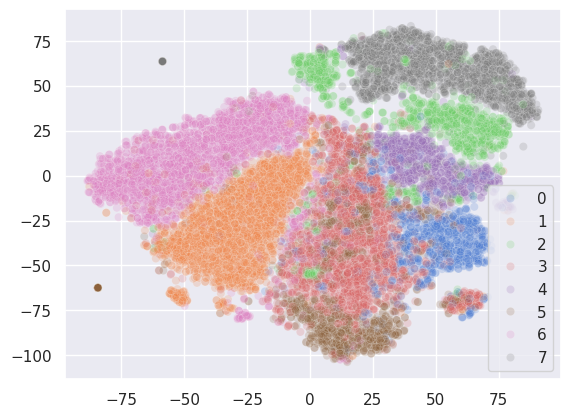

In [17]:
ax = sns.scatterplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    hue=np.ravel(labels),
    palette="muted",
    alpha=0.2,
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

In [18]:
junk_indices = np.load(PROFILING_DIR / "junk_indices.npy")
junk_support = np.zeros(embeddings.shape[0])
junk_support[junk_indices] = 1
junk_support

array([0., 0., 0., ..., 1., 1., 1.])

(-113.01289863586426, 92.52302284240723)

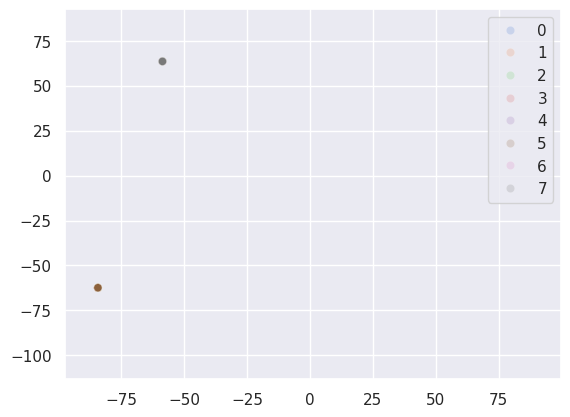

In [19]:
ax = sns.scatterplot(
    x=embeddings_tsne[junk_indices, 0],
    y=embeddings_tsne[junk_indices, 1],
    hue=np.ravel(labels[junk_indices]),
    palette="muted",
    alpha=0.2,
)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

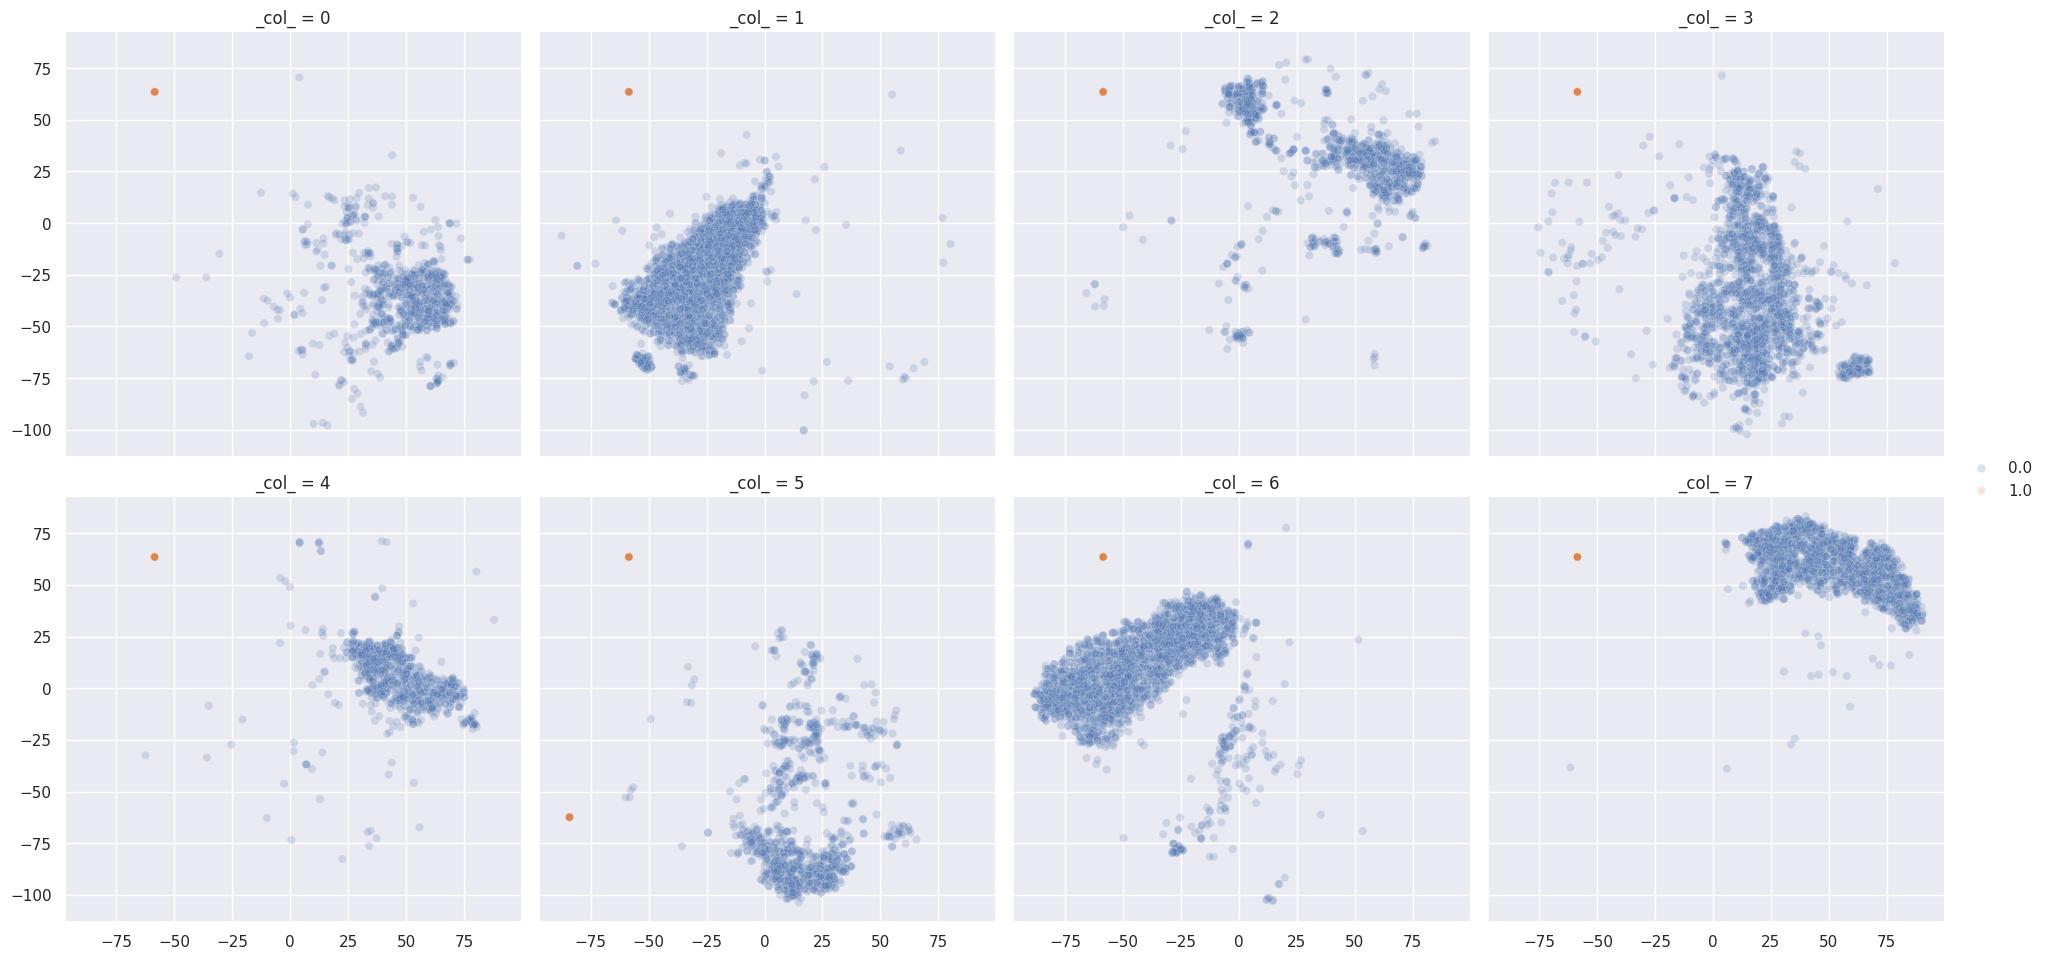

In [20]:
sns.relplot(
    x=embeddings_tsne[:, 0],
    y=embeddings_tsne[:, 1],
    col=np.ravel(labels),
    col_wrap=4,
    hue=junk_support,
    alpha=0.2,
)